In [1]:
import os
import rasterio as rio
import numpy as np
from osgeo import gdal
from osgeo import osr
import warnings
warnings.filterwarnings('ignore')

In [2]:
ip_dir = 'LC08_L1TP_140043_20180109_20180119_01_T1'

In [3]:
# Reading the bands
files = os.listdir(ip_dir)
i = j = 0

for file in files:
    # Finding bands
    if file.endswith("_B5.TIF"):
        i = i+1
        nir = rio.open(os.path.join(ip_dir, file))
    if file.endswith("_B4.TIF"):
        j = j+1
        red = rio.open(os.path.join(ip_dir, file))
# Checking the integrity of input files
if i>1 or j>1:
    raise Exception("Multiple input files within the input directory")
if i==0 or j==0:
    raise Exception("Unable to find input files")   
del i, j

In [4]:
# Conversion to array and NDVI calculation
nir_band = np.empty(shape = (nir.shape))
nir_band = nir.read(1).astype(float)
nir_band[np.where(nir_band==0)] = np.nan

red_band = np.empty(shape = (red.shape))
red_band = red.read(1).astype(float)
red_band[np.where(red_band==0)] = np.nan

ndvi = (nir_band-red_band)/ (nir_band+red_band)

In [5]:
def ReferencedGeocode(refRas, npArray,op_file_name):
    # Checking extension of the output file
    if op_file_name.endswith('.tif'):
        None
    else:
        op_file_name = op_file_name + '.tif'
        
    # Getting info for geocoding
    xmin, ymin, xmax, ymax = refRas.bounds
    nrows,ncols = np.shape(npArray)
    xres = (xmax-xmin)/float(ncols)
    yres = (ymax-ymin)/float(nrows)
    geotransform = xmin, xres, 0, ymax, 0, -yres 
    epsg_num = int(refRas.crs.data['init'].split(':')[1])
    
    # Applying the geocoding
    output_raster = gdal.GetDriverByName('GTiff').Create(op_file_name, ncols, nrows, 1, gdal.GDT_Float32)  
    output_raster.SetGeoTransform(geotransform)  # Specify its coordinates
    srs = osr.SpatialReference()                 # Establish its coordinate encoding
    srs.ImportFromEPSG(epsg_num)
    output_raster.SetProjection(srs.ExportToWkt()) 
    output_raster.GetRasterBand(1).WriteArray(npArray)
    output_raster.FlushCache()
    
    return rio.open(op_file_name)

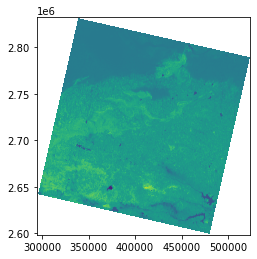

<AxesSubplot:>

In [6]:
ndvi_geo = ReferencedGeocode(nir, ndvi, "ndvi")
from rasterio.plot import show
show(ndvi_geo)